In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split,DataLoader
from torchvision.utils import make_grid
import torchvision.transforms  as transfroms
from torchvision.transforms import ToTensor

In [57]:
dataset = CIFAR100(root = './',train=True,transform=ToTensor(),download=True)
test_ds = CIFAR100('./',train=False,transform=ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
print(len(dataset))
print(len(test_ds))

50000
10000


In [59]:
classes = dataset.classes
print("num classes :",len(classes))
print(classes)

num classes : 100
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whal

torch.Size([3, 32, 32])
19
cattle


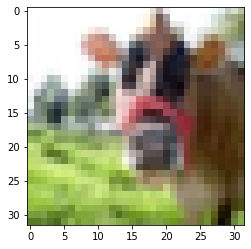

In [60]:
image,labels = dataset[0]
print(image.shape)
print(labels),print(dataset.classes[labels])
plt.imshow(image.permute(1,2,0))

# Dataset and Dataloader

In [61]:
valid_split  = 0.2
val_size = int(len(dataset) * valid_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [62]:
batch_size = 128
train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

# Visualising a batch of image

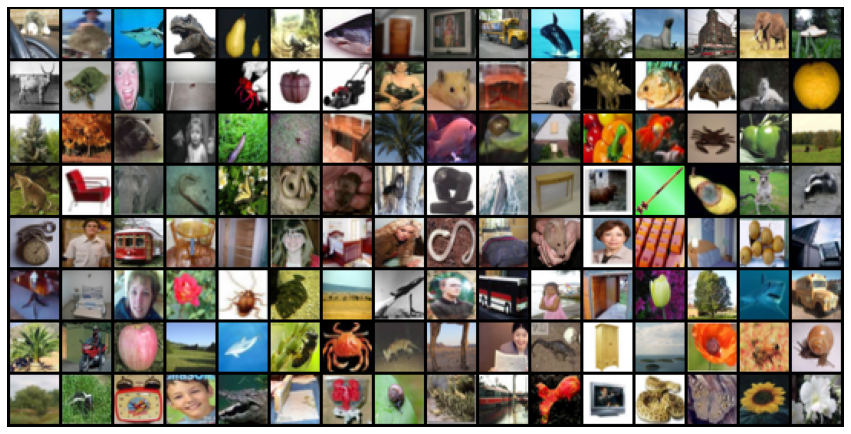

In [63]:
for images,labels in train_loader:
  plt.subplots(figsize=(15, 20))
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  plt.axis('off')
  break

# Building The model

In [64]:
def accuracy(outputs,labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Image_Classification_Base(nn.Module):

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['train_loss'], result['val_loss'], result['val_acc']))

In [65]:
input_shape = 32*32*3
num_classes = 100

In [66]:
class Cifar100_FeedForward(Image_Classification_Base):

  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(input_shape,64)
    self.linear2 = nn.Linear(64,128)
    self.linear3 = nn.Linear(128,256)
    self.linear4 = nn.Linear(256,512)
    self.linear5 = nn.Linear(512,1024)
    self.linear6 = nn.Linear(1024,num_classes)

  def forward(self,xb):
    out = self.flatten(xb)
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    return out

In [67]:
class Cifar100_CNN(Image_Classification_Base):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
       nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
       nn.ReLU(),
       nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
       nn.ReLU(),
       nn.MaxPool2d(2,2), #output 64*16*16

       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
       nn.ReLU(),
       nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
       nn.ReLU(),
       nn.MaxPool2d(2,2), #output 128*8*8

       nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
       nn.ReLU(),
       nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
       nn.ReLU(),
       nn.MaxPool2d(2,2), #output 256*4*4
       nn.AdaptiveAvgPool2d(1),
      
      nn.Flatten(),
      nn.Linear(256,512),
      nn.ReLU(),
      nn.Linear(512,1024),
      nn.ReLU(),
      nn.Linear(1024,num_classes)

      )

  def forward(self,xb):
    out = self.network(xb)
    return out

In [68]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def  fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  optimizer.zero_grad()
  for epoch in range(epochs):
    model.train()
    train_loss = []
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_loss.append(loss)
    result = evaluate(model,val_loader)
    train_losses = torch.stack(train_loss).mean()
    result['train_loss'] = train_losses.item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

# Using GPU

In [69]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [70]:
device = get_default_device()
device

device(type='cuda')

In [71]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [72]:
model = to_device(Cifar100_CNN(), device)

In [73]:
evaluate(model, val_loader)

{'val_acc': 0.009493670426309109, 'val_loss': 4.6056365966796875}

# Training the model

In [74]:
history = fit(10,0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0],train_loss: 4.3702, val_loss: 4.1675, val_acc: 0.0425
Epoch [1],train_loss: 4.0140, val_loss: 3.8963, val_acc: 0.0767
Epoch [2],train_loss: 3.7877, val_loss: 3.7186, val_acc: 0.1071
Epoch [3],train_loss: 3.5949, val_loss: 3.5218, val_acc: 0.1428
Epoch [4],train_loss: 3.3947, val_loss: 3.3210, val_acc: 0.1780
Epoch [5],train_loss: 3.1916, val_loss: 3.1974, val_acc: 0.2063
Epoch [6],train_loss: 3.0046, val_loss: 3.0675, val_acc: 0.2303
Epoch [7],train_loss: 2.8371, val_loss: 2.9354, val_acc: 0.2582
Epoch [8],train_loss: 2.6892, val_loss: 2.8387, val_acc: 0.2741
Epoch [9],train_loss: 2.5629, val_loss: 2.7135, val_acc: 0.3039


In [75]:
history += fit(10,0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0],train_loss: 2.4229, val_loss: 2.6178, val_acc: 0.3249
Epoch [1],train_loss: 2.3255, val_loss: 2.5767, val_acc: 0.3351
Epoch [2],train_loss: 2.2234, val_loss: 2.6308, val_acc: 0.3272
Epoch [3],train_loss: 2.1313, val_loss: 2.5335, val_acc: 0.3489
Epoch [4],train_loss: 2.0435, val_loss: 2.5049, val_acc: 0.3528
Epoch [5],train_loss: 1.9617, val_loss: 2.5298, val_acc: 0.3566
Epoch [6],train_loss: 1.8821, val_loss: 2.4312, val_acc: 0.3774
Epoch [7],train_loss: 1.7966, val_loss: 2.4466, val_acc: 0.3745
Epoch [8],train_loss: 1.7255, val_loss: 2.4841, val_acc: 0.3846
Epoch [9],train_loss: 1.6422, val_loss: 2.4691, val_acc: 0.3874


In [79]:
history += fit(10,0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0],train_loss: 1.5554, val_loss: 2.4699, val_acc: 0.3941
Epoch [1],train_loss: 1.4662, val_loss: 2.5468, val_acc: 0.3867
Epoch [2],train_loss: 1.4076, val_loss: 2.5398, val_acc: 0.4011
Epoch [3],train_loss: 1.3366, val_loss: 2.6083, val_acc: 0.3986
Epoch [4],train_loss: 1.2524, val_loss: 2.6520, val_acc: 0.3920
Epoch [5],train_loss: 1.1860, val_loss: 2.7028, val_acc: 0.3929
Epoch [6],train_loss: 1.1018, val_loss: 2.9704, val_acc: 0.3813
Epoch [7],train_loss: 1.0597, val_loss: 2.8603, val_acc: 0.3976
Epoch [8],train_loss: 0.9725, val_loss: 2.9876, val_acc: 0.3918
Epoch [9],train_loss: 0.8987, val_loss: 3.3034, val_acc: 0.3814


# Plotting Accuracy and Losses

In [80]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [81]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

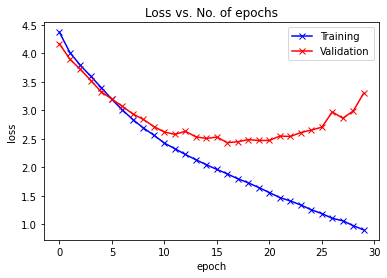

In [82]:
plot_losses(history)

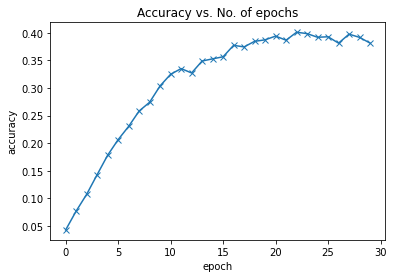

In [83]:
plot_accuracies(history)

# Evaluate the model on test data

In [84]:
evaluate(model, test_loader)

{'val_acc': 0.3937895596027374, 'val_loss': 3.2465736865997314}